<a href="https://colab.research.google.com/github/JCaballerot/Consultoria_ASEI/blob/main/Model_development/JesusMaria/modelDevelopment_zona1_JM_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5>Forecasting Jesus Maria Zona 1
</font></h1>

---

## Introducción



El presente documento tiene como objetivo exponer el desarrollo metodológico del modelo de predicción de venta de inmuebles elaborados para el distrito de <b>Jesús María - Zona 1</b>.



## Desarrollo general



El desarrollo metodológico utilizado consta de 4 etapas las cuales se dividen en:

>**1. Feature Engineering:** \
>
>Consiste en generar nuevas variables derivadas de las extraidas de las fuentes macro y ASEI. Ejemplo: Promedios de la variable y ratios de la variable en distintas ventanas. Este es un paso muy importante en el desarrollo de ML porque permitirá generar data estable y que pueda caracterizar la data de forma más completa.\
\
**2. Modelo ARIMA:** \
Generaremos un modelo ARIMA basado en el aprendizaje de la misma serie temporal tomando como input la misma serie y su comportamiento histórico. El objetivo principal acá será aprender de la tendencia y estacionariedad que presenta la serie temporal.\
\
**3. Modelo de regresión:**\
En esta etapa utilizaremos todas las variables macro y variables ASEI generadas previamente así como su feature engineering. El objetivo de este punto será generar un modelo que aprenda de la sensibilidad de las variables macro y ASEI respecto a nuestra variable objetivo (El precio del inmueble). La primera opción metodológica es un modelo VAR (de vectores autoregresivos), sin embargo si no se obtuvieran los resultados deseados se optó por un modelo de regresión lineal.\
\
**4. Ensamble de modelos:** \
Finalmente el último pasoconsiste en ensamblar los modelos desarrollados en la etapa 2 y 3, esto con el objetivo que ambos tengan un peso en la estimación final del número de ventas de inmuebles. En los modelos de Miraflores se usó la metodología de ensamble por medias y en Jesús María se utilizaron modelos var (Vectores autorregresivos) para ensamblar los modelos.

---

Resumen:

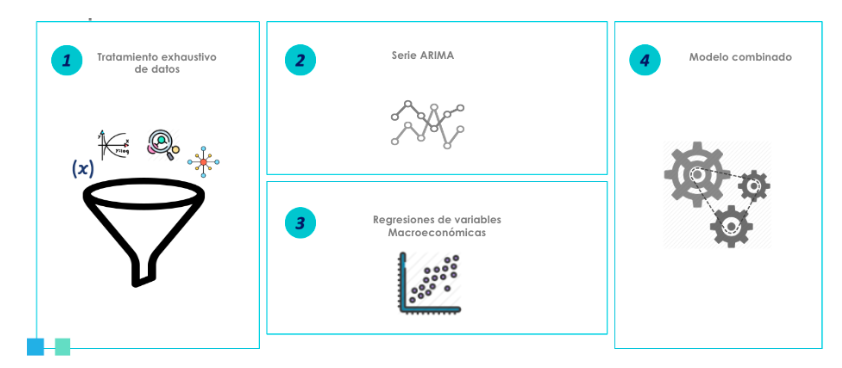

---

## Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item1">Importación de librerías y dependencias</a> \
2. <a href="#item2">Carga y preparación del Dataset</a> \
3. <a href="#item3">Modelo de forecasting</a> \
4. <a href="#item4">Pre-selección para regresión</a> \
5. <a href="#item5">Modelo de regresión</a> \
6. <a href="#item6">Ensamblado de modelos</a> \
7. <a href="#item7">Implementación</a> \

</font>
</div>

# 1. Importación de librerías y dependencias



Cargamos las librerías y principales dependencias que utilizaremos en el notebook.

---

In [1]:
# Cargando pandas
import pandas as pd

# Cargando numpy
import numpy as np
from numpy import log

# Cargando librerías gráficas
import matplotlib.pyplot as plt                  
import seaborn as sns                            

# Cargando sklearn para las métricas de evaluación
from sklearn.metrics import *

# Cargando limpieza de warnings durante las ejecuciones
import warnings                                  
warnings.filterwarnings('ignore')

# Librería para guardar objetos
import pickle

# Librerías necesarias para el entrenamiento de modelos
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


In [2]:
# Cargando funciones user defined

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",  color='red')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)

# 2. Carga y preparación del Dataset

Importamos la información desde un archivo csv cargado en el file temporal y nos quedamos con los datos que utilizaremos para el modelo.

---

In [3]:
# Configuración inicial

# Target a modelar
target = 'Venta_zona_1'

# datos de la zona a modelar
pddf = pd.read_csv('datos_jesusmaria.csv', delimiter=';', index_col=['codmes'], parse_dates=['codmes']).fillna(0)

# variables macro
macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])

# variables complementarias ASEI
asei = pd.read_csv('variables_asei_new.csv', delimiter = ';', index_col=['codmes'], parse_dates=['codmes'])


#### Tratamiento de la variable target



Generamos dataset con la variable objetivo y la rezagamos 2 y 3 meses (esto debido a que para su uso tendremos disponibles las ventas del mes pasado o de hace dos meses).

In [4]:
pddf = pddf[[target]]
pddf[target+'_lag2'] = pddf[target].shift(2)
pddf[target+'_lag3'] = pddf[target].shift(3)

#### Rezago de las variables ASEI


Generamos un rezago de 2 meses de las variables ASEI, esto debido a que la información estará disponible respecto al mes anterior de la estimación.


In [5]:
variables_asei = asei.columns.tolist()
asei[variables_asei] = asei[variables_asei].shift(2)


#### Rezago de las variables macro


Generamos un rezago de 3 meses de las variables macro, esto debido a que la información macro puede tener mayor demora de carga por las páginas que las reportan.


In [6]:
variables_macro = macro.columns.tolist()
macro[variables_macro] = macro[variables_macro].shift(3)


#### Cruce de información


Generamos la tabla maestra con todas las fuentes tratadas en pasos anteriores.


In [7]:
pddf2 = pd.merge(pddf,  macro, on = 'codmes', how='left').copy()
pddf2 = pd.merge(pddf2, asei, on = 'codmes', how='left')

variables = variables_macro + variables_asei + [target+'_lag2', target+'_lag3']

Generamos variables promedio de los últimos 3 y 6 meses de cada una de las variables analizadas.

In [8]:
pddfRes = pddf2.copy()

pddfRes[[x + '_avg3' for x in variables]] = pddfRes[variables].rolling(3, min_periods = 3).mean()
pddfRes[[x + '_avg6' for x in variables]] = pddfRes[variables].rolling(6, min_periods = 6).mean()

pddfRes = pddfRes.iloc[8:]
pddfRes['intercept'] = 1

Generamos variables ratio de evolución dividiendo las variables generadas en el paso anterior (3/6).

In [9]:
for x in variables:
  pddfRes[x + '_rat3to6'] = pddfRes[x + '_avg3']/pddfRes[x + '_avg6']
  

Guardamos en una lista todas las variables que probaremos.

In [10]:
variables_f = variables_macro +\
              variables_asei +\
              [target+'_lag2', target+'_lag3'] +\
              [x + '_avg3' for x in variables] +\
              [x + '_avg6' for x in variables] +\
              [x + '_rat3to6' for x in variables]


#### Generamos la base de test para el modelo

Tomamos sólo dos meses debido a que priorizaremos utilizar la información para el entrenamiento debido a que hay muy poco comportamiento en periodo post-covid.

In [11]:
test_size = 2

data = pddfRes.copy().dropna()
X_train = pddfRes[:-test_size].dropna()
X_test  = pddfRes[-test_size:].dropna()


Estandarizamos la data restándole a cada variable su media y dividiendo entre su respectiva desviación estándar.

In [12]:
# Estandarización
X_train[[x + '_std' for x in variables_f]] = (X_train[variables_f] - X_train[variables_f].mean())/X_train[variables_f].std()
X_test[[x + '_std'  for x in variables_f]] = (X_test[variables_f]  - X_train[variables_f].mean())/X_train[variables_f].std()
data[[x + '_std'    for x in variables_f]] = (data[variables_f]    - X_train[variables_f].mean())/X_train[variables_f].std()

# 3. Modelo de Forecasting

### Análisis gráfico

En el análisis gráfico tendremos una primera vista del comportamiento de la serie temporal, en este punto será necesario analizar cantidades mensuales, tendencias, estacionalidades y estacionariedades de forma gráfica para poder tomar desiciones de modelamiento más adelante.

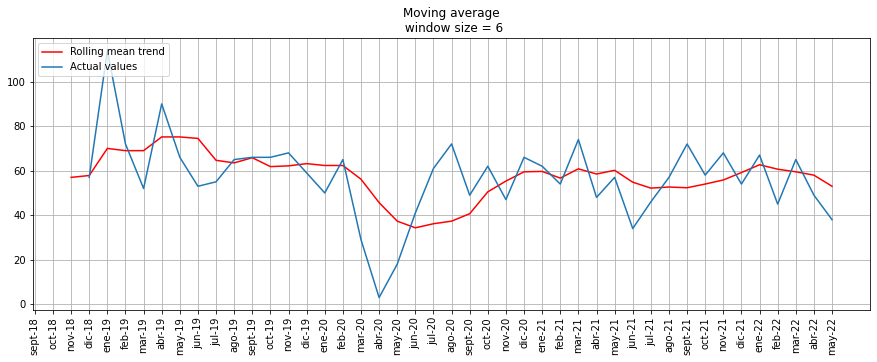

In [13]:
plotMovingAverage(data[target], 6)

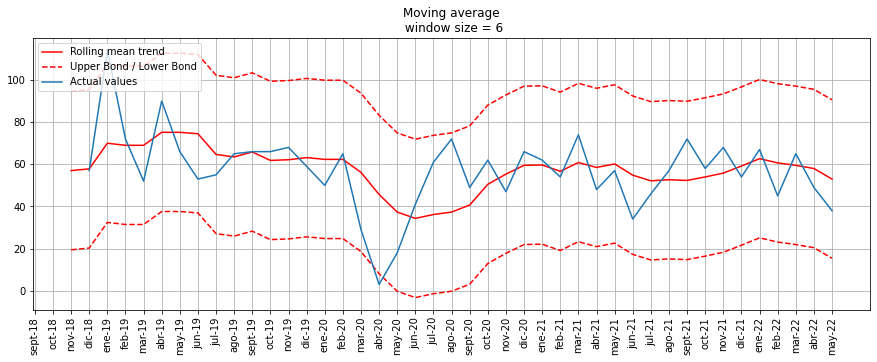

In [14]:
plotMovingAverage(data[target], 6, plot_intervals=True, scale=1.64, plot_anomalies=False)

La serie presenta tendencia negativa aparentemente es no estacionaria, lo cual implicaria un modelamiento de tipo ARIMA.

Prueba aumentada de dicky Fuller para estacionariedad.

In [15]:
result = adfuller(X_train[target].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.755990
p-value: 0.000066


El valor de p < 0.05 indica que con 95% de confianza se rechaza la Ho, es decir la serie temporal es no estacionaria lo que significa que será necesario modelar la serie con un enfoque ARIMA

#### I (d) 

Diferenciamos la serie para validar en que punto esta se vuelve estacionaria.

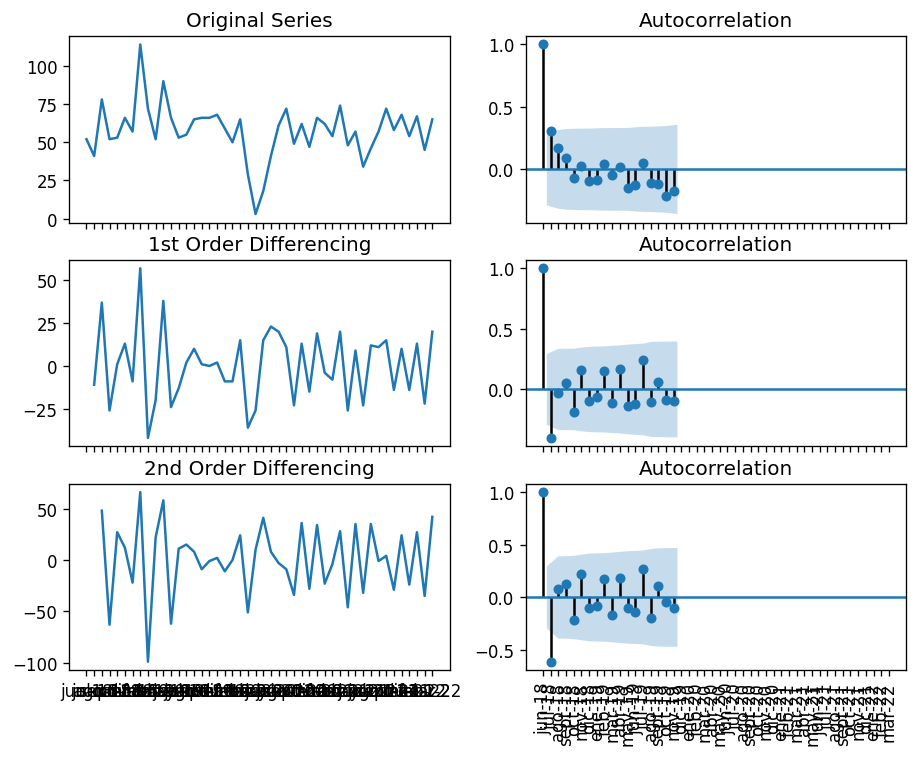

In [16]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train[target]); axes[0, 0].set_title('Original Series')
plot_acf(X_train[target], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train[target].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train[target].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train[target].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train[target].diff().diff().dropna(), ax=axes[2, 1])

plt.xticks(rotation=90)
plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con dos órdenes de diferenciación.

#### AR (p) 

Por otro lado el gráfico de autocorrelación parcial nos permitirá evaluar el grado de correlación para los términos rezagados de la serie.

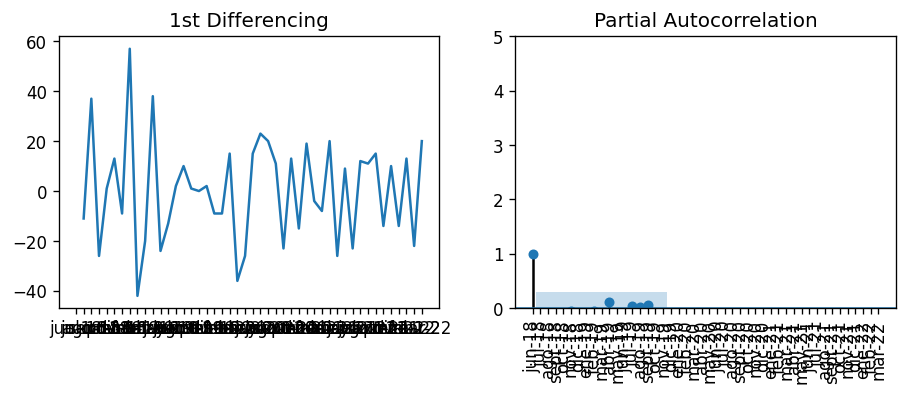

In [17]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(X_train[target].diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()

Podemos ver que el retraso 1 de PACF es bastante significativo ya que está muy por encima de la línea de significancia. Entonces, fijaremos el valor de p como 1.

#### MA (q) 

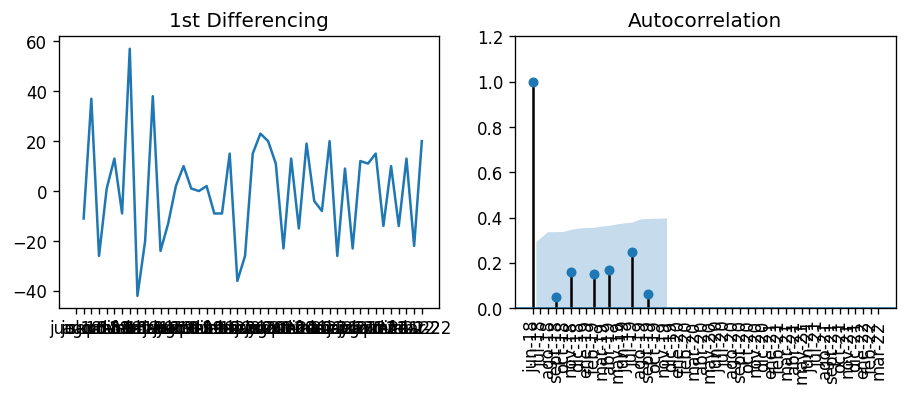

In [18]:

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(X_train[target].diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()


Podemos ver que un 1 retraso están muy por encima de la línea de significación. Entonces, fijaremos q como 1. Si hay alguna duda, iremos con el modelo más simple que explica suficientemente.

### Arima

Ahora, hemos determinado los valores de p, d y q. Disponemos de todo lo necesario para adaptarse al modelo ARIMA. Usaremos la implementación ARIMA() en el paquete statsmodels.
(p, d, q)

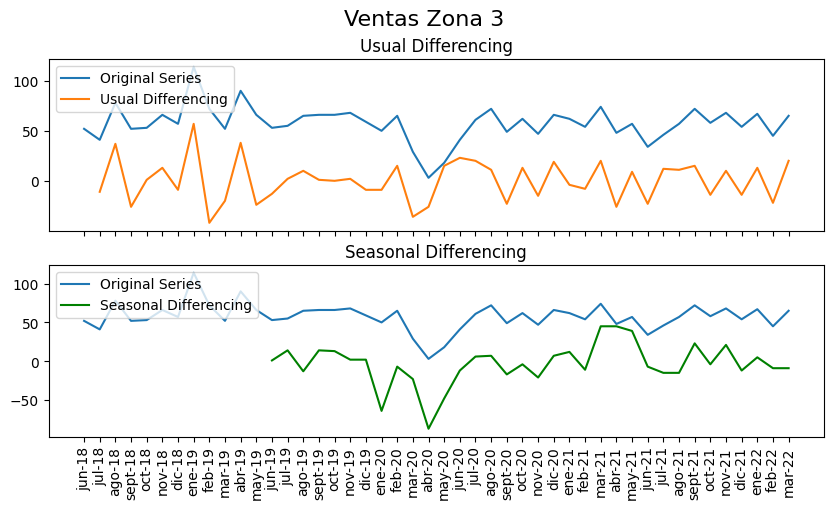

In [19]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X_train[target], label='Original Series')
axes[0].plot(X_train[target].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(X_train[target], label='Original Series')
axes[1].plot(X_train[target].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas Zona 3', fontsize=16)
plt.xticks(rotation=90)
plt.show()

Basandonos en el análisis previo definiremos un modelo ARIMA (1,2,1)

In [20]:

features = [target + '_lag3_avg3']

# 2,1,1 ARIMA Model
model = ARIMA(endog = X_train[target], 
              exog = X_train[features],  
              order=(1,2,1))

model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_1   No. Observations:                   44
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -194.030
Method:                       css-mle   S.D. of innovations             18.885
Date:                Thu, 29 Sep 2022   AIC                            398.060
Time:                        19:20:29   BIC                            406.981
Sample:                             2   HQIC                           401.369
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.8765      2.350      0.373      0.709      -3.730       5.483
Venta_zona_1_lag3_avg3    -0.0158      0.041     -0.383      0.702      -0.097       0.065
ar.L

Guardamos el objeto generado a raiz del entrenamiento

In [21]:
pickle.dump(model_fit, open("./arima_jmz1.ml", 'wb'))

Graficamos los resultados del modelo ARIMA para validar que la estimación guarda sentido.

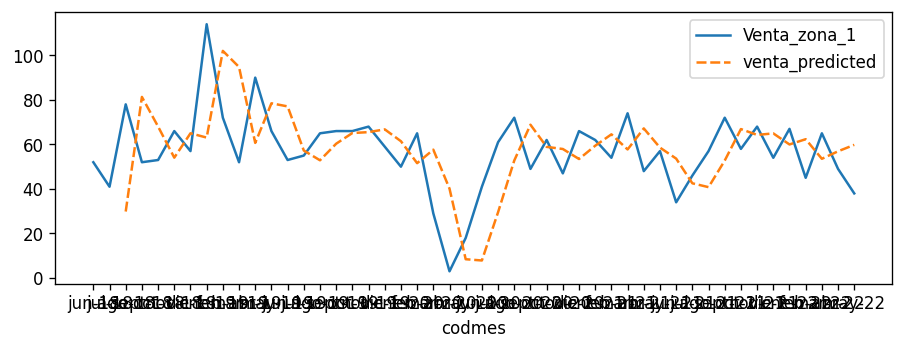

In [22]:

fc, se, conf  = model_fit.forecast(test_size, exog = X_test[features], alpha=0.05)
model_res = model_fit.predict(start = X_train.index[2], 
                                end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted'] = model_res
data_res.iloc[-test_size:]['venta_predicted'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted']])


Graficamos los residuos de la estimación para validar que dejemos solo aleatoriedad como residuo.

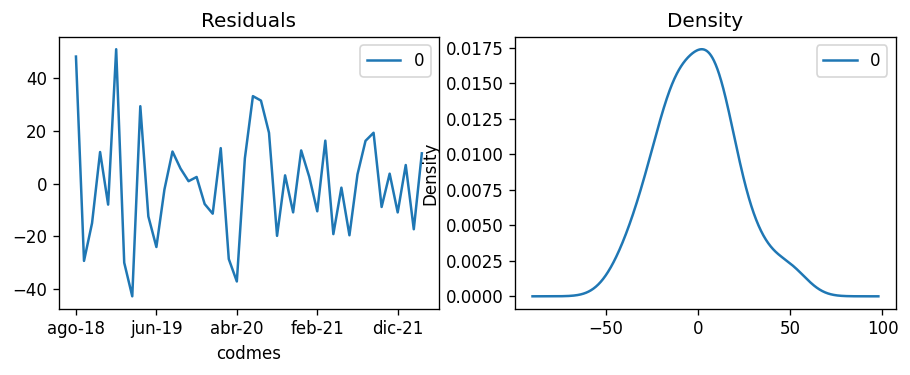

In [23]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen correctos con una media cercana a cero y una varianza uniforme. Grafiquemos los valores reales contra los valores ajustados usando plot_predict().

In [24]:
pd.set_option('display.max_rows', 500)

In [25]:
data_res[['venta_predicted', target]].head()

,venta_predicted,Venta_zona_1
codmes,,
jun-18,NaN,52
jul-18,NaN,41
ago-18,29.854771,78
sept-18,81.344880,52
oct-18,68.027737,53


Exportamos los resultados de la primera predicción

In [26]:
data_res[['venta_predicted',target]].to_csv('results_JM_zona1.csv', index=0)

Finalente evaluaremos los resultados en la ventana de test

In [27]:
data = data_res.copy().dropna()
X_train = data_res[:-test_size].dropna()
X_test  = data_res[-test_size:].dropna()

In [28]:
X_test[['venta_predicted', target]]

,venta_predicted,Venta_zona_1
codmes,,
abr-22,56.917399,49
may-22,59.811991,38


# 4. Pre-selección para regresión

Durante la etapa de pre-selección de variables calcularemos los r2 de cada una de las variables respecto a nuestra variable objetivo. Esto con la finalidad de encontrar aquellas que tengan mayor nivel de explicación de las ventas.

In [29]:
correlations = pd.DataFrame()

for col in variables_f:
  data_temp = X_train[[target, col]]
  correlation = data_temp[col].corr(data_temp[target])
  temp = pd.DataFrame({'target': [target],'variable': [col], 'correlacion' : [correlation]})
  correlations = correlations.append(temp)

correlations['correlacion_abs'] = correlations.correlacion.apply(lambda x: abs(x))
correlations['r2'] = correlations.correlacion.apply(lambda x: x**2)

correlations.sort_values(by = 'correlacion_abs', ascending = False, inplace = True)


In [35]:
correlations.head(30)

,target,variable,correlacion,correlacion_abs,r2
0,Venta_zona_1,precio_venta_zon1_rat3to6,-0.385472,0.385472,0.148589
0,Venta_zona_1,precio_venta_zon3_rat3to6,-0.365843,0.365843,0.133841
0,Venta_zona_1,ind_prec_inm_rat3to6,0.339881,0.339881,0.115519
0,Venta_zona_1,precio_venta_total_avg3,-0.292360,0.292360,0.085474
0,Venta_zona_1,precio_venta_total,-0.282303,0.282303,0.079695
0,Venta_zona_1,prod_ener_lima_rat3to6,0.260358,0.260358,0.067786
0,Venta_zona_1,precio_venta_total_avg6,-0.242221,0.242221,0.058671
0,Venta_zona_1,ind_prec_alt_rat3to6,0.232525,0.232525,0.054068
0,Venta_zona_1,precio_oferta_zon3_avg3,-0.229010,0.229010,0.052445
0,Venta_zona_1,precio_oferta_zon3_avg6,-0.226980,0.226980,0.051520


de las variables anteriormente mostradas tomaremos aquellas que cumplan con sentido económico, criterio de explicabilidad y además cumplan con significancia estadística en la regresión mostrada debajo.

# 5. Modelo de regresión

Luego de probar distintas regresiones en base al anterior resumen de pre-selección mostramos la regresión propuesta (no se muestran las regresiones no válidas para no extender el documento, sin embargo cualquier otra combinación de variables probadas en el paso anterior podrían ser evaluadas para retar la regresión propuesta).

In [33]:

features = ['intercept', 'ind_prec_inm_rat3to6_std', 'ind_prec_inf_suby_bienes_avg6_std']

# Fit and summarize OLS model
mod = sm.OLS(X_train[target], 
             X_train[features])

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Venta_zona_1   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     5.614
Date:                Thu, 29 Sep 2022   Prob (F-statistic):            0.00700
Time:                        19:26:23   Log-Likelihood:                -182.87
No. Observations:                  44   AIC:                             371.7
Df Residuals:                      41   BIC:                             377.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
interc

Las variables cumplen con el criterio de significancia del 95% (p<0.05).

Otro criterio importante que deberán cumplir las variables escogidas será que no se encuentren altamente correlacionadas. El análisis de correlaciones mostrado debajo evidencia que no hay niveles los suficientemente altos como para descartar la independencia de variables.

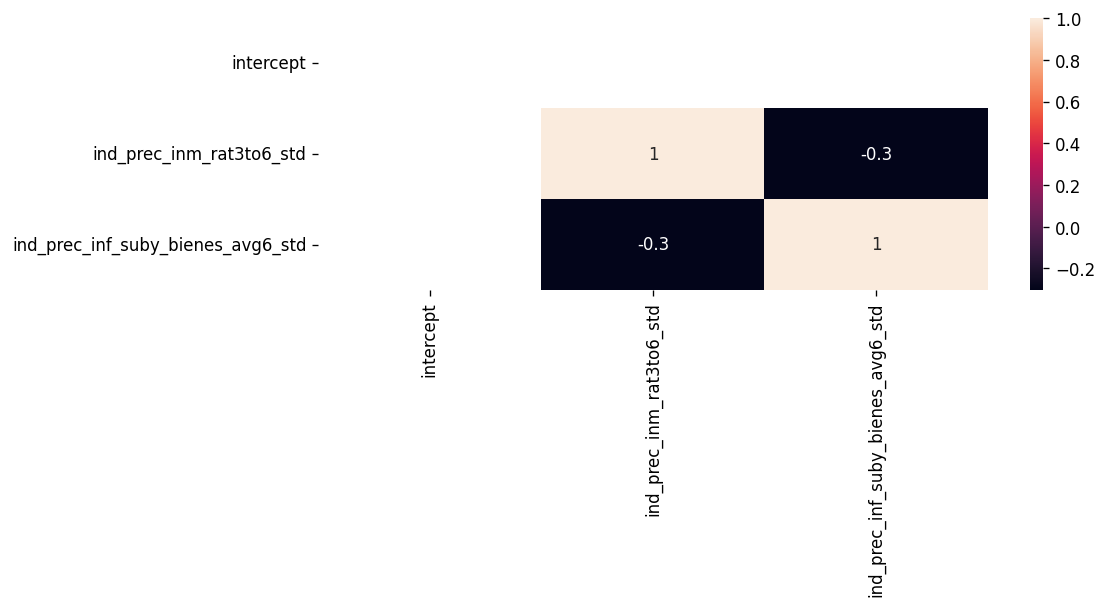

In [37]:
sns.heatmap(X_train[features].corr(), annot=True)
plt.show()

Extraemos la regresión y la utilizamos para puntuar todo el dataset

In [39]:
data_res['macro_pred'] = 57.6329 + 7.6093*data_res.ind_prec_inm_rat3to6_std + 5.9194*data_res.ind_prec_inf_suby_bienes_avg6_std

data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()


# 6. Modelo de Ensamble

En este paso desarrollaremos un modelo de Vectores autorregresivos para ensamblar las predicciones obtenidas por el modelo ARIMA y el modelo de regresión.

In [43]:
#target + '_lag3_avg3'
ensemble = ['venta_predicted', 'macro_pred']

# 2,1,1 ARIMA Model
model_ff = ARIMA(endog = X_train[target], 
                 exog = X_train[ensemble],  
                 order=(1,2,1))

model_fit_ff = model_ff.fit()
print(model_fit_ff.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_1   No. Observations:                   42
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -183.694
Method:                       css-mle   S.D. of innovations             18.178
Date:                Thu, 29 Sep 2022   AIC                            379.389
Time:                        19:41:01   BIC                            389.815
Sample:                             2   HQIC                           383.210
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.2984      5.381      0.241      0.809      -9.249      11.846
venta_predicted          -0.0777      0.043     -1.789      0.074      -0.163       0.007
macro_pr

En este punto se recomienda el uso de esta metodología pese a que la significancia de las variables no cumple con los niveles seteados inicialmente (95% de confianza) debido a que de todas formas es más recomendable tener los efectos macroeconómicos incorporados dentro del proceso de estimación del modelo.

Guardamos el objeto entrenado

In [45]:
pickle.dump(model_fit_ff, open("./var_jmz1.ml", 'wb'))

Graficamos los resultados para corroborar que la estimación del modelo ajuste al comportamiento de los datos

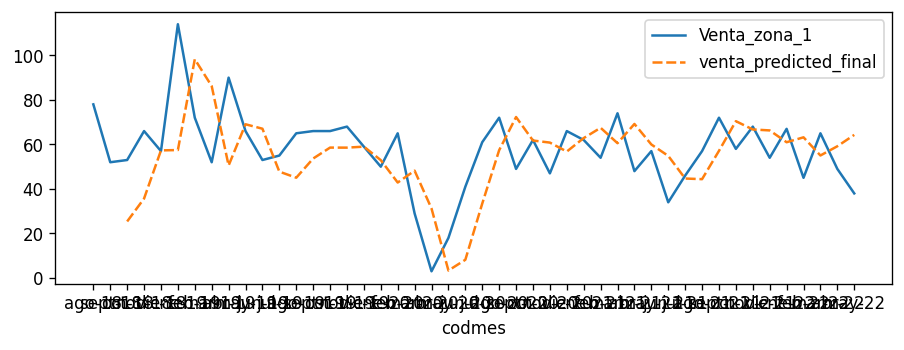

In [46]:

fc, se, conf  = model_fit_ff.forecast(test_size, 
                                      exog = X_test[['venta_predicted', 'macro_pred']], alpha=0.05)

model_res = model_fit_ff.predict(start = X_train.index[2], 
                                 end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted_final'] = model_res
data_res.iloc[-test_size:]['venta_predicted_final'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted_final']])


Exportamos datos

In [47]:
data_res[[target, 'venta_predicted', 'macro_pred', 'venta_predicted_final']]

,Venta_zona_1,venta_predicted,macro_pred,venta_predicted_final
codmes,,,,
ago-18,78,29.854771,46.151464,NaN
sept-18,52,81.344880,51.063465,NaN
oct-18,53,68.027737,62.766374,25.395690
nov-18,66,54.055231,71.138221,35.686093
dic-18,57,65.004536,79.754243,57.319764
ene-19,114,63.069729,73.432620,57.475907
feb-19,72,102.021251,66.271547,98.272801
mar-19,52,94.778900,55.486042,86.208139
abr-19,90,60.682221,54.707229,50.532597


# 7. Implementación

A continuación hacemos una pequeña implementación del modelo (no es la implementación final) con la finalidad de proyectar algunas de las estimaciones del modelo.

primero, necesitamos un dataset con los inputs iniciales

In [50]:
data[['Venta_zona_1_lag3_avg3', 'ind_prec_inm_rat3to6_std', 'ind_prec_inf_suby_bienes_avg6_std']].head()

,Venta_zona_1_lag3_avg3,ind_prec_inm_rat3to6_std,ind_prec_inf_suby_bienes_avg6_std
codmes,,,
ago-18,64.666667,-0.840546,-0.859120
sept-18,64.000000,-1.163055,0.385276
oct-18,52.000000,-0.036072,0.913599
nov-18,57.000000,1.085778,0.885784
dic-18,57.000000,2.202530,0.905773


Segundo, vamos a asumir que los factores macro se mantienen y que las ventas varian según lo proyectado

In [ ]:
input = pd.DataFrame({'Venta_zona_1_lag3_avg3' : [57, 60, 58, 59, 58, 58],
                      'ind_prec_inm_rat3to6_std' : [-0.273022]*6,
                      'ind_prec_inf_suby_bienes_avg6_std' : [2.846129]*6
                      },
                      index = ['jun-22', 'jul-22', 'ago-22', 'sept-22', 'oct-22', 'nov-22'])

Tercero, puntuamos con el modelo ARIMA



In [ ]:
fc_pred, se, conf  = model_fit.forecast(6, exog = input['Venta_zona_1_lag3_avg3'], alpha=0.05)
input['venta_predicted'] = fc_pred
fc_pred

Cuarto, puntuamos con el modelo de regresión

In [ ]:

input['macro_pred'] = 57.6329 + 7.6093*input.ind_prec_inm_rat3to6_std + 5.9194*input.ind_prec_inf_suby_bienes_avg6_std


Finalmente, obtenemos las predicciones finales utilizando el modelo VAR sobre las dos predicciones anteriores.

In [ ]:

fc_pred, se, conf  = model_fit_ff.forecast(6, exog = input[['venta_predicted', 'macro_pred']], alpha=0.05)
input['venta_predicted_final'] = fc_pred
input['venta_predicted_final']
fc_pred




---



---

Fin del notebook

---